# Introduction  

**!Recommend to view the notebook on Github!**  
Github Link : https://github.com/heartcored98/CH485_AI_Chemistry/blob/master/Practice2_Tox21_SVM/Assignment2_Tox21_SVM.ipynb

In this jupyter notebook, a toxicity of the molecular will be classified with the **Multi Layer Perceptron(MLP)** on **Tox21** dataset.  
**Tox21** dataset consists of molecular smile strings as inputs and binary labels as outputs.  

This notebook has following features  
- Convert smile string into _Morgan Fingerprints_(error handling enabled) with **RDkit**  
- Synthesis _insufficient class data_ by **imblearn SMOTE** algorithm in order to handle class imbalanced dataset 
- Support data spliting for _K-fold vallidation_ process easily
- Train and test multiple experiments of various hyperparameter sets _in parallel_ with **multiprocessing Pool**
- Manage experiment and model _hyperparameters_ at once with **argparse**  
- _Visualize_ experiment results with minimal changes of codes with **seaborn** and **pandas Dataframe**  

Throughout the notebook, there are **5** experiments with following investigation purpose.  
Note that **classification performance** includes _binary classification accuracy_ and _roc-auc metric._  
1. Influence of the **fingerprint dimension** toward **classification performance**.  
2. Influence of the **kernel** in the SVC model toward **classification performance**.  
3. Influence of the **C** coefficient toward **classification performance** among different **kernels**.  
4. Influence of the **gamma** coefficient toward **classification performance** among different **kernels**.  
5. Influence of the **C** and **gamma** coefficients toward **classification performance**.  


In [1]:
import time
from torch.multiprocessing import Pool, Process, set_start_method
from copy import deepcopy
import argparse
import sys
import traceback

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils import data
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import *

try:
     set_start_method('spawn')
except RuntimeError:
    pass

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.seed = 123
args.nbits = 2048
args.n_splits = 5
args.test_size = 0.2
args.batch_size=128
args.shuffle = True


np.random.seed(args.seed)
torch.manual_seed(args.seed)
list_tox_type = ['nr-ahr', 'nr-ar-lbd', 
                 'nr-ar', 'nr-aromatase', 
                 'nr-er-lbd', 'nr-er', 
                 'nr-ppar-gamma', 'sr-are', 
                 'sr-atad5', 'sr-hse', 
                 'sr-mmp', 'sr-p53']


# Prepare Dataset by Generating Molecular Fingerprints  

Since the molecular information is provided within **smile** string form, we need to convert this strings into fixed-dimension feature vector. 
For this purpose, a **Morgan Fingerprints** methods was very suitable as it produces fixed-size vector with given dimension while capturing chemical information as well.  

You can produce fingerprint with specified dimension with arguments **nBits**  
Also, there are some **smile** string which cannot be converted into fingerprints so we excluded them during dataset preparation.  

`RDkit` Fingerprint Ref : http://www.rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints

In [2]:
dict_partition = dict()
for tox_type in list_tox_type:
    args.tox_type = tox_type
    X, y = make_dataset(args)
    list_partition = make_partition(X, y, args)
    dict_partition[args.tox_type] = list_partition

## Dictionary saves experiment results with their hyperparatemr

In [3]:
exp_data = dict()

# MLP Model Architecture Define

The structure of the MLP mainly consists of linear layer, ReLU activation layer and dropout layer.  
At the end of the model, a sigmoid layer is adopted.

In [4]:
def construct_model(args):
    list_module = list()
    list_module += [nn.Linear(args.input_dim, args.hidden_dim), nn.ReLU()]

    if args.n_layer-2 > 2:
        for _ in range(args.n_layer-2):
            list_module.append(nn.Linear(hidden_dim))
            list_module.append(nn.ReLU())
            if args.dropout_rate > 0:
                list_module.append(nn.Dropout(args.dropout_rate))
            
    list_module.append(nn.Linear(args.hidden_dim, args.output_dim))
    list_module.append(nn.Sigmoid())
    
    model = nn.Sequential(*list_module)
    return model 

In [ ]:
""" Test code to construct MLP classifier 
args.input_dim = 2048
args.hidden_dim = 256
args.output_dim = 1
args.dropout_rate = 0.2
args.n_layer = 3
model = construct_model(args)
"""

# Experiment Template  

This section includes template code for launching individual experiments with given hyperparameters and experiment settings such as kernel type, C, gamma, fingerprint dimension, number of dataset fold and etc.  

- Data synthesis for insufficient class is shown during k-folding dataset.   
- Also, it includes function to execute each experiments in subprocess in order to maximize system resource utlization.
- **args** object contains all the hyperparameters and experiments settings to control the experiments.  

sklearn **k-fold** Ref : http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold  
**apply_async** Ref : https://stackoverflow.com/questions/8533318/multiprocessing-pool-when-to-use-apply-apply-async-or-map  
Using **SMOTE** Ref : https://beckernick.github.io/oversampling-modeling/  
Using Custom **Dataset** and **DataLoader** Ref : https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel 

In [5]:
def train(model, partition, optimizer, criterion, args):
    
    best_test_acc = 0
    cnt_iter = 0
    dict_train_loss = dict()
    dict_val_loss = dict()
    
    data_iter = DataLoader(
        partition['train'],
        batch_size=args.batch_size,
        shuffle=args.shuffle
    )
    
    for epoch in range(args.epoch):
        epoch_train_loss = 0
        for batch_idx, batch in enumerate(data_iter):
            X, y = Variable(batch[0]), Variable(batch[1])
            X, y = X.to(args.device).float(), y.to(args.device).float()
            y = y.view(-1, 1)

            model.train()
            optimizer.zero_grad()
            
            pred_y = model(X)
            pred_y.require_grad = False
            train_loss = criterion(pred_y, y)
            epoch_train_loss += train_loss.item()
            train_loss.backward()
            optimizer.step()
            
            cnt_iter += 1
            
        dict_train_loss[cnt_iter/len(data_iter)] = train_loss.item()
        val_loss = validate(model, partition, criterion, args)
        dict_val_loss[cnt_iter/len(data_iter)] = val_loss
           
    return model, pd.Series(dict_train_loss), pd.Series(dict_val_loss)

def validate(model, partition, criterion, args):
    epoch_val_loss = 0
    model.eval()
    data_iter = DataLoader(
        partition['val'],
        batch_size=args.batch_size,
        shuffle=args.shuffle
    )
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_iter):
            X, y = Variable(batch[0]), Variable(batch[1])
            X, y = X.to(args.device).float(), y.to(args.device).float()
            y = y.view(-1, 1)
            pred_y = model(X)
            
            val_loss = criterion(pred_y, y)
            epoch_val_loss += val_loss.item()
            
    return epoch_val_loss / len(data_iter)

def evaluate(model, partition, args):
    model.eval()
    data_iter = DataLoader(
        partition['test'],
        batch_size=args.batch_size,
        shuffle=args.shuffle
    )
    
    with torch.no_grad():
        list_accu = list()
        for batch_idx, batch in enumerate(data_iter):
            X, y = Variable(batch[0]), Variable(batch[1])
            X, y = X.to(args.device).float(), y.to(args.device).float()
            y = y.view(-1, 1)

            pred_y = model(X)
            target = y >= 0.5
            output = pred_y >= 0.5
            acc = float(output.eq(target).sum()) / target.numel()
            list_accu.append(acc)
            
    return np.array(list_accu).mean()

In [6]:
def experiment(partition, args):
    model = construct_model(args)
    model.to(args.device)
    criterion = nn.BCELoss()
    
    # Initialize Optimizer
    if args.optim == 'ADAM':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'RMSProp':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.l2_coef)
    else:
        assert False, "Undefined Optimizer Type"
        
    model, sr_train_loss, sr_val_loss = train(model, partition, optimizer, criterion, args)
    accu = evaluate(model, partition, args)
    return accu, sr_train_loss, sr_val_loss

In [11]:
def kfold_experiment(list_partition, args):    
    list_accu = list()
    for partition in list_partition:
        accu, str_train_loss, sr_val_loss = experiment(partition, args)
        list_accu.append(accu)
    return np.array(list_accu).mean(), np.array(list_accu).std()

In [27]:
def subproc_experiment(args):
    ts = time.time()
    try:
        list_partition = args.list_partition
        acc_mean, acc_std = kfold_experiment(list_partition, args)
        te = time.time()
        
        result = {"acc_mean":acc_mean, "acc_std":acc_std, 'elapsed':te-ts}
        temp_args = vars(args)
        del temp_args['list_partition']
        result.update(temp_args)
        
    except Exception as e:
        args.msg = traceback.print_tb(e.__traceback__)
    return result
    
def callback_experiment(result):
    
    result = deepcopy(result)    
    output = "Acc Mean: {:0.3f} Acc STD: {:0.3f} Elapsed: {:3.1f}"
    output = output.format(result['acc_mean'],
                           result['acc_std'],
                           result['elapsed'])
    print(output)
    
    global exp_data
    list_experiments = exp_data.get(args.exp_name, [])
    list_experiments.append(result)

# Test Experiment

In [ ]:
args.input_dim = 2048
args.hidden_dim = 128
args.output_dim = 1
args.n_layer = 2
args.dropout_rate = 0.2
args.lr = 0.01
args.l2_coef = 0
args.optim = 'ADAM'
args.epoch = 30
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.exp_name = 'exp_test'
args.list_partition = dict_partition['nr-ahr']
result = subproc_experiment(args)


In [ ]:
callback_experiment(result)

In [ ]:
print(result)
print(exp_data)

# Experiemnt1. Effect of Hidden Unit

In this experiment, molecular fingerprints would be calculated with different nbits values. If the value of the nbits is too low, then fingerprint vector would not represent important information. Otherwise, if the value of the nbits is too high, then fingerprint vector would be sparse so that model would less capture important feature from the fingerprint vector  

**Pandas Dataframe** construction Ref : http://pbpython.com/pandas-list-dict.html  
**Linear SVC** Ref : http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html  
**SVC** Ref : http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [28]:
%%time
args.exp_name = 'exp_hidden_dim'
args.input_dim = 2048
args.output_dim = 1
args.n_layer = 2
args.dropout_rate = 0.2
args.lr = 0.01
args.l2_coef = 0
args.optim = 'ADAM'
args.epoch = 30
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

exp_data['exp_hidden_dim'] = list()
list_hidden_dim = [32,64,128,256,512, 1024, 2048, 4096, 8192]

# pool = Pool(processes=14)
for tox_type in list_tox_type[:1]:
    for hidden_dim in list_hidden_dim:
        args.tox_type = tox_type
        args.hidden_dim = hidden_dim
        args.list_partition = dict_partition[tox_type]
        result = subproc_experiment(args)
        callback_experiment(result)
#         pool.apply_async(subproc_experiment, args = (args,), callback=callback_experiment)

# pool.close()
# pool.join()

Acc Mean: 0.941 Acc STD: 0.007 Elapsed: 27.8
Acc Mean: 0.944 Acc STD: 0.007 Elapsed: 27.7
Acc Mean: 0.943 Acc STD: 0.007 Elapsed: 28.5
Acc Mean: 0.945 Acc STD: 0.008 Elapsed: 28.5
Acc Mean: 0.949 Acc STD: 0.008 Elapsed: 28.6
Acc Mean: 0.948 Acc STD: 0.013 Elapsed: 28.5
Acc Mean: 0.949 Acc STD: 0.007 Elapsed: 29.8
Acc Mean: 0.948 Acc STD: 0.009 Elapsed: 41.0
Acc Mean: 0.948 Acc STD: 0.008 Elapsed: 71.0
CPU times: user 4min 35s, sys: 29.3 s, total: 5min 4s
Wall time: 5min 11s


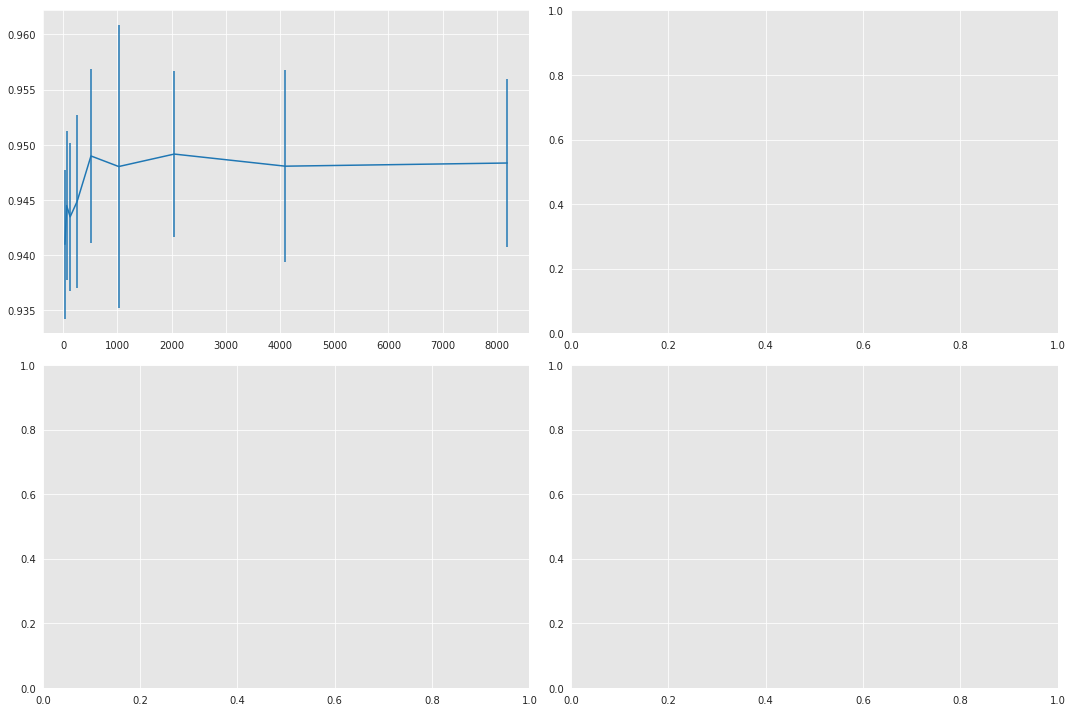

In [31]:
df = pd.DataFrame(exp_data['exp_hidden_dim'])
df = df[['acc_mean', 'acc_std', 'elapsed', 'tox_type', 'hidden_dim']]

fig, ax = plt.subplots(2, 2)
fig.set_size_inches(15, 10)


sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# grid = sns.lineplot(x="hidden_dim", y="acc_mean", hue="tox_type", markers=True, data=df, ax=ax[0][0])
# grid = sns.pointplot(x="hidden_dim", y="acc_mean", hue="tox_type", data=df, ci='acc_std', )

ax1 = ax[0][0]
ax1.errorbar(df["hidden_dim"], df["acc_mean"], df["acc_std"])
# grid.set_title("Accuracy vs hidden_dim")
# grid.set(xscale="log")
# grid.grid(True)

"""
grid = sns.lineplot(x="hidden_dim", y="acc_mean", hue="tox_type", data=df, ax=ax[0][1])
grid.set_title("ROC-AUC vs nbits")
grid.set(xscale="log")
grid.grid(True)

df_accu = df.pivot(index='tox_type', columns='nbits', values='accu')
grid = sns.heatmap(df_accu, annot=True, ax=ax[1][0])
grid.set_title("Binary Classification Accuracy")

df_roc_auc = df.pivot(index='tox_type', columns='nbits', values='roc_auc')
grid = sns.heatmap(df_roc_auc, annot=True, ax=ax[1][1])
grid.set_title("ROC-AUC")
"""
plt.tight_layout()
plt.grid(True)

## Result and Discussion  

Above figures shows accuracy and roc-auc value change over dimension of the fingerprints.  
The figures in the upper row are plotted with line-chart to deliver the tendency among variables.  
The figures in the lower row are plotted with heatmap to deliver exact accuracy and roc-auc value.  

**Experiment Settings.**   
- Tested dimensions were [1, 4, 16, 64, 256, 1024, 2048, 4096] and higher dimensions were not tested since it took long computation time.  
- All 12 toxicity types were tested in order to observe the general effect of vector size.  
- A linear kernel was used due to its superior computation speed. C and gamma value were selected as 1.0 and 1/n_feature, respectively. 
- All results were derived from the 5-fold valdiation process  

**Notable Results.**    
- Both accuracy and roc-auc are increased while the dimension of the fingerprints increase. 
- When vector size is 1 and 4, auc-roc is almost 0.5 which means that the classifier cannot distinguish the input which is reasonable result since too many information are condensed into just few elements.  
- It is notable that accuracy and roc-auc were around 0.9 when vector size is more than 2048 without any hyperparameter optimization 

# Experiment2. Effect of Kernel

In [ ]:
%%time

args.nbits = 64
args.seed = 123
args.C = 1.0
args.gamma = 'auto'
args.n_splits = 5
args.exp_name = 'exp_kernel'

exp_data['exp_kernel'] = list()
list_kernel = ['linear', 'poly', 'rbf', 'sigmoid']

pool = mp.Pool(processes=14)
for tox_type in list_tox_type[:]:
    for kernel in list_kernel:
        args.tox_type = tox_type
        args.kernel = kernel
        pool.apply_async(subproc_experiment, args = (deepcopy(args),), 
                         callback=callback_experiment)

pool.close()
pool.join()

In [ ]:
df = pd.DataFrame(exp_data['exp_kernel'])
df = df[['accu', 'roc_auc', 'kernel', 'tox_type']]

fig, ax = plt.subplots(2, 2)
fig.set_size_inches(15, 10)


sns.set_style("darkgrid", {"axes.facecolor": ".9"})

grid = sns.lineplot(x="kernel", y="accu", hue="tox_type", markers=True, data=df, ax=ax[0][0])
grid.set_title("Accuracy vs kernel")
grid.grid(True)

grid = sns.lineplot(x="kernel", y="roc_auc", hue="tox_type", data=df, ax=ax[0][1])
grid.set_title("ROC-AUC vs kernel")
grid.grid(True)

df_accu = df.pivot(index='tox_type', columns='kernel', values='accu')
grid = sns.heatmap(df_accu, annot=True, ax=ax[1][0])
grid.set_title("Binary Classification Accuracy")

df_roc_auc = df.pivot(index='tox_type', columns='kernel', values='roc_auc')
grid = sns.heatmap(df_roc_auc, annot=True, ax=ax[1][1])
grid.set_title("ROC-AUC")

plt.tight_layout()
plt.grid(True)

## Result and Discussion  

Above figures shows accuracy and roc-auc value change over type of the kernel.  
The figures in the upper row are plotted with line-chart to deliver the tendency among variables.  
The figures in the lower row are plotted with heatmap to deliver exact accuracy and roc-auc value.  

**Experiment Settings.**  
- Tested kernel were ['linear', 'poly', 'rbf', 'sigmoid'].  
- All 12 toxicity types were tested in order to observe the general effect of kernel type.  
- 64 dimension was selected for the fingerprint vector size in order to reduce the experiment time.  
- Default C and gamma value were selected as 1.0 and 1/n_feature, respectively. 
- All results were derived from the 5-fold valdiation process  

**Notable Results.**  
- The performance of accuracy and roc-auc were decreased in order of 'rbf' > 'poly' > 'linear' > 'sigmoid'. 
- The order of the performance among different tox_type was almost consisent aganist the kernel type that it might  imply each tox_type dataset has it own data complexity.  

# Experiment3. Effect of 'C' coef of SVC

In [ ]:
%%time

args.nbits = 64
args.seed = 123
args.gamma = 'auto'
args.n_splits = 5
args.kernel = 'poly'
args.exp_name = 'exp_C'
args.tox_type = 'nr-ahr'

exp_data['exp_C'] = list()
list_C = [ i for i in range(1, 40, 3)]
list_kernel = ['poly', 'linear', 'rbf', 'sigmoid']

pool = mp.Pool(processes=14)
for kernel in list_kernel[:]:
    for C in list_C:
        args.kernel = kernel
        args.C = C
        pool.apply_async(subproc_experiment, 
                         args = (deepcopy(args),), 
                         callback=callback_experiment)

pool.close()
pool.join()

In [ ]:
df = pd.DataFrame(exp_data['exp_C'])
df = df[['accu', 'roc_auc', 'C', 'kernel', 'elapsed']]

fig, ax = plt.subplots(3, 2)
fig.set_size_inches(15, 15)


sns.set_style("darkgrid", {"axes.facecolor": ".9"})

grid = sns.lineplot(x="C", y="accu", hue="kernel", markers=True, data=df, ax=ax[0][0])
grid.set_title("Accuracy vs C")
grid.grid(True)

grid = sns.lineplot(x="C", y="roc_auc", hue="kernel", data=df, ax=ax[0][1])
grid.set_title("ROC-AUC vs C")
grid.grid(True)

df_accu = df.pivot(index='kernel', columns='C', values='accu')
grid = sns.heatmap(df_accu, annot=True, ax=ax[1][0])
grid.set_title("Binary Classification Accuracy")

df_roc_auc = df.pivot(index='kernel', columns='C', values='roc_auc')
grid = sns.heatmap(df_roc_auc, annot=True, ax=ax[1][1])
grid.set_title("ROC-AUC")

df_accu = df.pivot(index='kernel', columns='C', values='elapsed')
grid = sns.heatmap(df_accu, annot=True, ax=ax[2][0], cmap='jet')
grid.set_title("Elapsed Time (sec)")

ax[-1, -1].axis('off')

plt.tight_layout()
plt.grid(True)

## Result and Discussion  

Above figures shows accuracy and roc-auc value change over C value.  
The figures in the upper row are plotted with line-chart to deliver the tendency among variables.  
The figures in the middel row are plotted with heatmap to deliver exact accuracy and roc-auc value.  
The figure in the lower row is plotted with heatmap to deliver execution time.  

**Experiment Settings.**  
- Tested C values were [1,4,7,10,13,16,19,22,25,28,31,34,37].  
- 4 kernel types: ['linear', 'poly', 'rbf', 'sigmoid'] were tested in order to observe the general effect of C towrad a kernel type.  
- 64 dimension was selected for the fingerprint vector size in order to reduce the experiment time.  
- Default gamma value was selected as 1/n_feature. 
- Only tested with 'nr-ahr' tox_type. 
- All results were derived from the 5-fold valdiation process  

**Notable Results.**  
- In 'poly' and 'rbf' the performance of accuracy and roc-auc were increased with C value. 
- On the other hands, in 'sigmoid', 'linear' the accuracy was unstable with C value.  
- In 'sigmoid', 'linear' the roc-auc seems decreased with C value. 

# Experiment4. Effect of 'gamma' coef of SVC

In [ ]:
%%time

args.nbits = 64
args.seed = 123
args.C = 1.0
args.n_splits = 5
args.exp_name = 'exp_gamma'
args.tox_type = 'nr-ahr'

exp_data['exp_gamma'] = list()
list_gamma = [ 10**i for i in range(-4, 5)]
list_kernel = ['poly', 'rbf', 'sigmoid']

pool = mp.Pool(processes=14)
for kernel in list_kernel[:]:
    for gamma in list_gamma:
        args.kernel = kernel
        args.gamma = gamma
        pool.apply_async(subproc_experiment, 
                         args = (deepcopy(args),), 
                         callback=callback_experiment)

pool.close()
pool.join()

In [ ]:
df = pd.DataFrame(exp_data['exp_gamma'])
df = df[['accu', 'roc_auc', 'gamma', 'kernel', 'elapsed']]

fig, ax = plt.subplots(3, 2)
fig.set_size_inches(15, 15)


sns.set_style("darkgrid", {"axes.facecolor": ".9"})

grid = sns.lineplot(x="gamma", y="accu", hue="kernel", markers=True, data=df, ax=ax[0][0])
grid.set_title("Accuracy vs gamma")
grid.grid(True)
grid.set(xscale="log")

grid = sns.lineplot(x="gamma", y="roc_auc", hue="kernel", data=df, ax=ax[0][1])
grid.set_title("ROC-AUC vs gamma")
grid.grid(True)
grid.set(xscale="log")

df_accu = df.pivot(index='kernel', columns='gamma', values='accu')
grid = sns.heatmap(df_accu, annot=True, ax=ax[1][0])
grid.set_title("Binary Classification Accuracy")

df_roc_auc = df.pivot(index='kernel', columns='gamma', values='roc_auc')
grid = sns.heatmap(df_roc_auc, annot=True, ax=ax[1][1])
grid.set_title("ROC-AUC")

df_accu = df.pivot(index='kernel', columns='gamma', values='elapsed')
grid = sns.heatmap(df_accu, annot=True, ax=ax[2][0], cmap='jet')
grid.set_title("Elapsed Time (sec)")

ax[-1, -1].axis('off')

plt.tight_layout()
plt.grid(True)

## Result and Discussion  

Above figures shows accuracy and roc-auc value change over gamma value.  
The figures in the upper row are plotted with line-chart to deliver the tendency among variables.  
The figures in the middel row are plotted with heatmap to deliver exact accuracy and roc-auc value.  
The figure in the lower row is plotted with heatmap to deliver execution time.  

**Experiment Settings.**  
- Tested C values were 10^[-4, -3, -2, -1, 0, 1, 2, 3, 4].  
- 3 kernel types: ['poly', 'rbf', 'sigmoid'] were tested in order to observe the general effect of gamma towrad a kernel type('linear' was excluded since it does not have gamma parameter).  
- 64 dimension was selected for the fingerprint vector size in order to reduce the experiment time.  
- Default C value was selected as 1.0. 
- Only tested with 'nr-ahr' tox_type. 
- All results were derived from the 5-fold valdiation process  

**Notable Results.**  
- Overally, there were some interval of the gamma value where the performance is maximized for each kernel type.  
- For example, 'poly' and 'rbf' were maximized around 0.1~10.0 and 'sigmoid' was maximized around 0.01.  
- 'sigmoid' was worst kernel type. 

# Experiment5. Simultaneous Effect of 'gamma' and 'C' coef of SVC

Gamma and C Ref : http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

In [ ]:
%%time

args.nbits = 64
args.seed = 123
args.C = 1.0
args.n_splits = 5
args.exp_name = 'exp_c_gamma'
args.tox_type = 'nr-ahr'
args.kernel = 'rbf'

exp_data['exp_c_gamma'] = list()
list_C = [ 4**i for i in range(-4, 4)]
list_gamma = [ 5**i for i in range(-3, 4)]
print("Total {} Cases".format(len(list_C)*len(list_gamma)))

pool = mp.Pool(processes=14)
for C in list_C[:]:
    for gamma in list_gamma:
        args.C = C
        args.gamma = gamma
        pool.apply_async(subproc_experiment, 
                         args = (deepcopy(args),), 
                         callback=callback_experiment)

pool.close()
pool.join()

In [ ]:
df = pd.DataFrame(exp_data['exp_c_gamma'])
df = df[['accu', 'roc_auc', 'gamma', 'C', 'elapsed']]

fig, ax = plt.subplots(3, 2)
fig.set_size_inches(15, 15)


sns.set_style("darkgrid", {"axes.facecolor": ".9"})

grid = sns.lineplot(x="C", y="accu", hue="gamma", markers=True, data=df, ax=ax[0][0])
grid.set_title("Accuracy vs gamma")
grid.grid(True)

grid = sns.lineplot(x="C", y="roc_auc", hue="gamma", data=df, ax=ax[0][1])
grid.set_title("ROC-AUC vs gamma")
grid.grid(True)

df_accu = df.pivot(index='C', columns='gamma', values='accu')
grid = sns.heatmap(df_accu, annot=True, ax=ax[1][0])
grid.set_title("Binary Classification Accuracy")

df_roc_auc = df.pivot(index='C', columns='gamma', values='roc_auc')
grid = sns.heatmap(df_roc_auc, annot=True, ax=ax[1][1])
grid.set_title("ROC-AUC")

df_accu = df.pivot(index='C', columns='gamma', values='elapsed')
grid = sns.heatmap(df_accu, annot=True, ax=ax[2][0], cmap='jet')
grid.set_title("Elapsed Time (sec)")

ax[-1, -1].axis('off')


plt.tight_layout()
plt.grid(True)

## Result and Discussion  

Above figures shows accuracy and roc-auc value change over gamma and C value.  
The figures in the upper row are plotted with line-chart to deliver the tendency among variables.  
The figures in the middel row are plotted with heatmap to deliver exact accuracy and roc-auc value.  
The figure in the lower row is plotted with heatmap to deliver execution time.  

**Experiment Settings.**
- Tested C values were 4^[-4, -3, -2, -1, 0, 1, 2, 3].  
- Tested gamma values were 5^[-3, -2, -1, 0, 1, 2, 3].
- Best performing 'rbf' kernel was selected.  
- 64 dimension was selected for the fingerprint vector size in order to reduce the experiment time.  
- Only tested with 'nr-ahr' tox_type. 
- All results were derived from the 5-fold valdiation process  

**Notable Results.**  
- It is worth to pay attention to the figures in the middle row. There are **highlighted** area with in the middle of the heatmap.
- It is observable that accuracy is maximized at C: 1.0~4.0 and gamma: 0.2~25.0 and the roc-auc is maximized at C: 0.0625~0.25 and gamma: 0.2~1.0.    
- Suprisingly, the model achieves 96% on binary classification with 0.96 roc-auc area value with only 64 dimension finger prints with hyperparameter grid searching!  

# Possible Improvements

1. Fine tune the model with Hyperparameter Searching Tool.   
2. Increase the dimension of the fingerprints to encode sufficient information.  
3. Applying different data augumentation method except SMOTE.  